# Pokemon Image Classification
> Training pipeline

In [ ]:
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb
from collections import OrderedDict
from notes.misc import *

In [ ]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'pokemon_image_classification.ipynb'

wandb.init(project='pokemon_image_classification')

wandb: Currently logged in as: andrewtruong (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Load data

In [ ]:
path = Path('../../data/pokemon')
files = get_image_files(path)

In [ ]:
def img2rgb(img):
    return img.convert('RGB')

In [ ]:
datasets = Datasets(
    files,
    tfms=[[PILImage.create, img2rgb], [parent_label, Categorize]],
    splits=RandomSplitter()(files)
)

In [ ]:
dataloaders = datasets.dataloaders(
    after_item=[ToTensor, RandomResizedCrop(224)],
    after_batch=[IntToFloatTensor],
    bs=128,
)

/home/andrew/miniconda/envs/fastpages/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


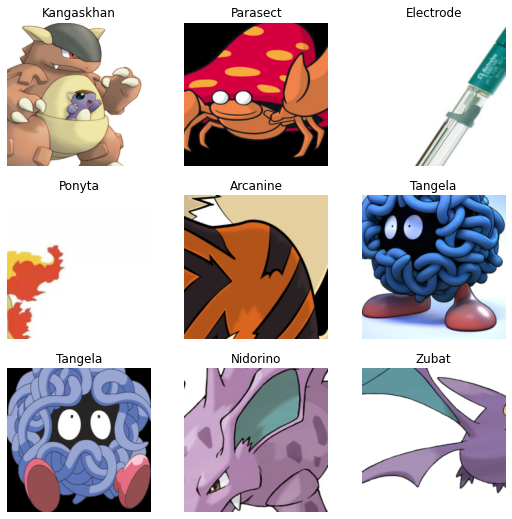

In [ ]:
dataloaders.show_batch()

## Model

In [ ]:
model = nn.Sequential(OrderedDict([
    ('body', create_body(xresnet50, cut=-4)),
    ('head', create_head(2048, 151, lin_ftrs=[2048]))
]))

In [ ]:
learner = Learner(
    dataloaders,
    model,
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, top_k_accuracy],
#     cbs=[SaveModelCallback, WandbCallback],
    cbs=[SaveModelCallback, ShowGraphCallback]
)

In [ ]:
@patch
def show_activations(self: Learner, img):
    img = Path(img)
    pipeline = Pipeline([PILImage.create, ToTensor, Resize(224, method='squish'), IntToFloatTensor])
    x = pipeline(img).unsqueeze(0)
    # y, name = img.parent.name.split('-')
    # y = int(y)
    y = 0
    name = 'Farfetchd'

    with HookBwd(learner.model.body) as hookg:
        with Hook(learner.model.body) as hook:
            output = learner.model.eval()(x)
            act = hook.stored
        output[0,y].backward()
        grad = hookg.stored


    w = grad[0].mean(dim=[1,2], keepdim=True)
    cam_map = (w * act[0]).sum(0)

    
    _,ax = plt.subplots()
    x[0].show(ctx=ax)
    ax.title.set_text(name)
    ax.imshow(cam_map.detach().cpu(), alpha=0.80, extent=(0,224,224,0),
                  interpolation='sinc', cmap='magma_r')

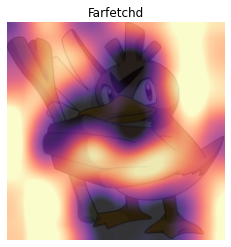

In [ ]:
learner.show_activations(files[0])

/home/andrew/miniconda/envs/fastpages/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/andrew/miniconda/envs/fastpages/lib/python3.8/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (91670000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


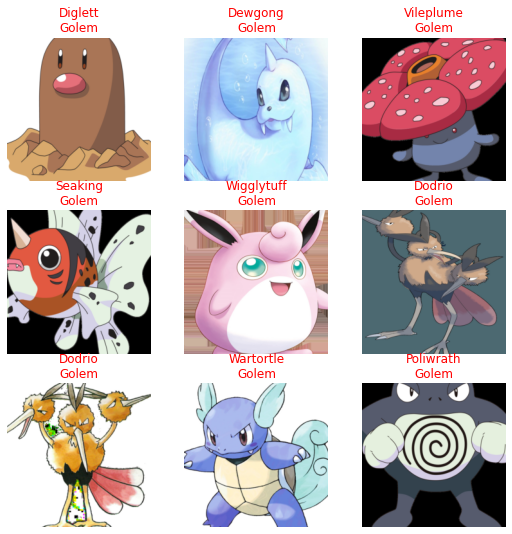

In [ ]:
learner.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

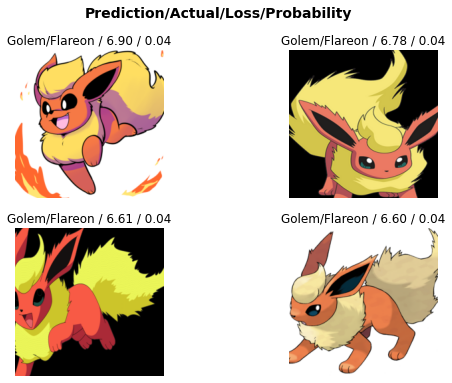

In [ ]:
interp.plot_top_losses(4, figsize=(9,6))